# **[멋쟁이사자처럼_AI_NLP] 03. CNN 예제**

## 1. CV란?

- CV(Computer Vision)
- 이미지나 비디오와 같은 시각적 데이터를 분석하고 이해하는 인공지능의 한 분야
- 인공지능은 사람이 규칙을 설정하는 것이 아니라 데이터에 잠재되어 있는 특징을 학습한다.
- 따라서 인공지능 모델이 학습하는 과정이 필요하고 많은 데이터가 필요하다.
- 목표: 인간의 시각적 인지 능력을 모방하여 자동으로 정보를 추출하고, 이를 기반으로 다양한 작업 수행

## 2. 사용할 라이브러리

In [4]:
import torch
import torch.nn as nn                # 신경망 구조 정의용 (Linear, Conv 등)
import torch.optim as optim          # 옵티마이저 (SGD, Adam 등)
import torchvision                   # torchvision: 이미지 관련 데이터셋/모델/변환 제공
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt      # 시각화용 (이미지, 학습 곡선 등)
import numpy as np
# import cv2                           # OpenCV - 이미지 처리용

## 3. 사용할 데이터 및 전처리

- 딥러닝과 머신러닝의 전처리 차이점
    - 특징(feature)을 사람이 직접 추출하느냐, 혹은 인공지능이 데이터의 잠재적인 특징을 찾아내느냐
    - 이것이 원천 데이터(raw data) 그대로 사용해도 된다는 의미는 아님
- 방식 자체는 데이터마다, task와 모델에 따라 다르지만 대표적인 전처리 방식
    - 노이즈 제거: 결측값(NAN 값), 측정 오류, 불필요한 정보 제거
    - 정규화(noramalization)와 표준화(standardization): 변수들이 다양한 단위나 범위를 가질 수 있기 때문에 특성이 비슷한 범위에서 비교 가능하도록 정규화 또는 표준화.
        - 학습이 더 안정적으로 이루어지고 특정 특성이 과도하게 영향을 미치는 것을 방지할 수 있다.
    - 차원 축소: 전처리를 통해 필요 없는 특성(feature)을 제거하거나 PCA 같은 차원 축소 기법 사용해 중요한 특성만 남김.
        - 고차원 데이터는 모델이 학습하기 어렵고 계산 비용이 높아짐.
    - 데이터 균형: 데이터 샘플링 기법을 사용하여 데이터의 균형을 맞춤.
        - 분류 문제에서 특정 클래스가 너무 적거나 많아 모델이 한쪽으로 치우친 예측을 방지.
    - 포멧 변환: 모델이 데이터를 처리할 수 있는 형식으로 변환.
        - 토큰화(tokenization)
        - 이미지 데이터를 정해진 크기로 변환하거나 픽셀 값을 정규화하는 작업

In [6]:
# GPU/CPU 장치 설정 - GPU가 사용 가능하면 CUDA 장치 사용, 아니면 CPU 사용
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 이미지 전처리 파이프라인 정의
# - Resize: 입력 이미지를 224x224 크기로 맞춤 (ResNet 등 사전학습 모델 입력 크기)
# - ToTensor: 이미지를 Tensor로 변환 (0~255 -> 0~1 범위)
# - Normalize: ImageNet 학습 시 사용된 평균/표준편차로 정규화
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Oxford-IIIT Pet 데이터셋 로드 (학습용&테스트용)
# - root="./data": 데이터 다운로드/저장 경로
# - split="trainval": train + validation 세트
# - target_types="category": 레이블은‘품종 카테고리’
# - transform: 위에서 정의한 전처리 적용
# - download=True: 데이터가 없으면 자동 다운로드
train_data = datasets.OxfordIIITPet(root="./data", split="trainval", target_types="category", transform=transform, download=True)
test_dataset = datasets.OxfordIIITPet(root="./data", split="test", target_types="category", transform=transform, download=True)

# 검증/테스트 세트 분리
# test 데이터셋을 다시 6:4 비율로 나누어 검증(validation)과 테스트(test)로 분할
val_size = int(0.6 * len(test_dataset))
test_size = len(test_dataset) - val_size

# random_split로 데이터셋을 무작위로 분할
val_data, test_data = random_split(test_dataset, [val_size, test_size])

# DataLoader 정의
# DataLoader는 데이터를 배치(batch) 단위로 묶고, GPU 학습에 효율적으로 전달
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)  # 학습용 (셔플 OFF)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)     # 검증용 (셔플 OFF)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)   # 테스트용 (셔플 OFF)

100%|██████████| 792M/792M [34:41<00:00, 380kB/s]   
100%|██████████| 19.2M/19.2M [00:24<00:00, 772kB/s] 


In [7]:
print("train data의 수 :", len(train_data))
print("validation data의 수 :", len(val_data))
print("test data의 수 :", len(test_data))

train data의 수 : 3680
validation data의 수 : 2201
test data의 수 : 1468


- Train data: 모델이 직접 보고 학습하는 데이터
- validation data: 모델이 잘 학습하고 있는지 확인하는 데이터. (단, 이 데이터는 모델이 직접 학습하지는 않는다.)
- test_data: 학습이 완료된 상태에서 모델의 최종 성능 확인하는 데이터.

In [9]:
# 총 37가지 품종의 강아지와 고양이 데이터로 이루어져 있음.
print(len(train_data.classes))

37


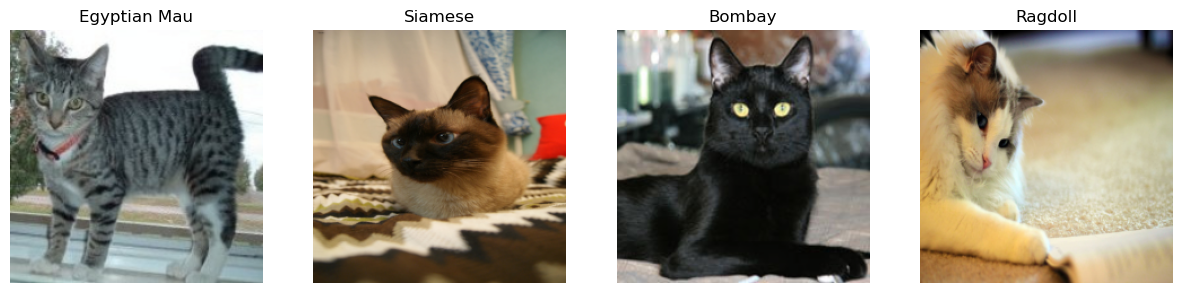

In [10]:
# 이미지 시각화 함수 정의
def imshow(img, ax, title=None):
    # ImageNet 정규화(mean/std) 복원용 배열
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # PyTorch Tensor는 (C, H, W)이므로 -> (H, W, C)로 변경 (matplotlib 시각화용)
    img = img.numpy().transpose((1, 2, 0))

    # 정규화 해제 (Normalize의 역과정)
    # 학습용 전처리에서 빼준 평균과 표준편차를 다시 적용해서 원래 색감 복원
    img = std * img + mean

    # 값의 범위를 0~1 사이로 클리핑 (imshow가 처리할 수 있는 범위)
    img = np.clip(img, 0, 1)

    # 이미지 표시
    ax.imshow(img)

    # 제목이 있으면 그래프 위에 표시
    if title is not None:
        ax.set_title(title)

    # 축 제거 (x, y 눈금 숨김)
    ax.axis("off")

# 학습 데이터셋에서 이미지 배치 하나 꺼내기
dataiter = iter(train_loader)
images, labels = next(dataiter)     # 한 배치(32개 중 일부) 반환

# 샘플 이미지 4개를 시각화
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    # 이미지 표시 + 클래스 이름(title로 출력)
    imshow(images[i], axs[i], title=train_data.classes[labels[i]])

plt.show()      # 이미지 창 띄우기

In [11]:
labels[:4]

tensor([11, 32,  7, 26])

## 4. 모델 빌드

In [12]:
# 사전학습된 VGG16 모델 불러오기
# - weights=models.VGG16_Weights.IMAGENET1K_V1: ImageNet 데이터로 학습된 가중치 사용
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

# 출력층 수정 (Transfer Learning 핵심)
# - 원래 VGG16의 마지막 FC층은 1000 클래스 (ImageNet)
# - Oxford-IIIT Pet 데이터셋은 37개의 동물 품종 -> 37개로 변경
model.classifier[6] = nn.Linear(4096, 37)

# GPU/CPU 장치로 모델 이동
model = model.to(device)

# 특징 추출기(feature extractor) 부분 동결
# - VGG16의 convolutional feature 부분은 학습하지 않음 (사전학습된 특성 유지)
# - 대신 classifier(FC 층)만 학습해서 효율적인 전이학습 수행
for param in model.features.parameters():
    param.requires_grad = False

# 모델 구조 확인 (특히 classifier 부분 출력)
model.classifier

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\user/.cache\torch\hub\checkpoints\vgg16-397923af.pth


100%|██████████| 528M/528M [00:43<00:00, 12.7MB/s] 


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=37, bias=True)
)

In [13]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## 5. 모델 학습

- 인공지능 모델은 데이터를 한 번만 학습하는 것이 아니라 여러번 반복해서 학습.
- 전체 데이터를 1회 학습하는 것을 1 epoch.
- 반복 횟수를 비롯한 하이퍼파라미터는 validation data를 통해 조절.
- 오버피팅(overfiting) 현상: 너무 많은 반복 학습 외에도 데이터셋의 크기에 비해 모델의 크기가 너무 크거나 학습률이 클 경우에도 발생
    - 너무 많이 반복하게 되면 학습한 데이터는 매우 잘 맞추지만 이외의 데이터에서는 일반화 성능이 떨어지며 적당히 학습했을 때보다 오히려 더 많이 틀리게 된다.

In [14]:
# 손실 함수 정의
# CrossEntropyLoss: 다중 클래스 분류 문제에서 자주 사용되는 손실 함수
criterion = nn.CrossEntropyLoss()

# 옵티마이저 정의
# - Adam: 학습 속도가 빠르고 안정적인 최적화 알고리즘
# - model.classifier.parameters(): 분류기(FC층)만 학습하도록 설정(featured은 동결했기 때문)
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("사용 중인 디바이스:", device)
model.to(device)

# 모델 학습 함수 정의
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=1):
    # 전체 학습을 num_epochs 만큼 반복
    for epoch in range(num_epochs):
        # 학습 모드로 전환 (Dropout, BatchNorm 등 활성화)
        model.train()

        running_loss = 0.0      # 누적 손실값
        correct = 0             # 정답 개수
        total = 0               # 전체 샘플 수

        # 배치 단위 학습 루프
        for inputs, labels in train_loader:
            # 데이터를 GPU(CUDA)로 이동
            inputs, labels = inputs.to(device), labels.to(device)

            # 옵티마이저 기울기 초기화
            optimizer.zero_grad()

            # 모델 예측값 계산(순전파)
            outputs = model(inputs)

            # 손실 계산
            loss = criterion(outputs, labels)

            # 역전파(gradient 계산)
            loss.backward()

            # 가중치 업데이트
            optimizer.step()

            # 손실값 누적
            running_loss += loss.item()

            # 예측된 클래스 인덱스 반환
            _, predicted = torch.max(outputs, 1)

            # 정답 개수 세기
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # 한 epoch의 학습 정확도 계
        train_accuracy = 100 * correct / total

        # 학습 결과 출력
        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Loss: {running_loss/len(train_loader): .4f}, "
              f"Train Accuracy: {train_accuracy: .2f}%", end=" ")

        # 검증 단계(Validation)
        model.eval()        # 평가 모드로 전환 (Dropout, BatchNorm 비활성화)
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        # 평가 시에는 기울기 계산 비활성화 (메모리/속도 절약)
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # 검증 정확도 계
        val_accuracy = 100 * val_correct / val_total

        # 검증 결과 출력
        print(f"Validation Loss: {val_loss/len(val_loader):.4f}, "
              f"Validation Accuracy: {val_accuracy:.2f}%")

        # 학습 모드로 다시 전환
        model.train()


# 학습 함수 실행(1epoch만 테스트)
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=1)

사용 중인 디바이스: cpu
Epoch [1/1], Loss:  1.3610, Train Accuracy:  75.68% Validation Loss: 1.3706, Validation Accuracy: 72.60%


## 6. 모델 평가

In [20]:
# 모델 성능 평가 함수 정의
def evaluate_model(model, test_loader):
    model.eval()        # 평가 모드로 전환
    correct = 0
    total = 0

    # 평가 중에는 gradient 계산 비활성
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)        # 각 샘플별 가장 높은 확률의 클래스 선택
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # 테스트 정확도 출력
    print(f"Test Accuracy: {100 * correct / total: 2f}%")

# 테스트 세트로 모델 평가
evaluate_model(model, test_loader)

Test Accuracy:  70.980926%


In [21]:
# CNN 특징맵(Feature Map) 시각화 함수 정의
def visualize_feature_maps(model, input_image, num_layer):
    # 모델을 평가 모드로 설정(Dropout/BatchNorm 비활성화)
    model.eval()
    outputs = []        # forward hook으로 받은 feature map 저장용
    names = []          # layer 이름 저장용

    # Hook 함수 정의
    # forward hook: forward 실행 시 특정 레이어의 출력을 받아올 수 있음
    def hook_fn(module, input, output):
        outputs.append(output)
        names.append(module.__class__.__name__)

    # 모델의 모든 convolution layer에 hook 등록
    hooks = []
    for layer in model.features:
        if isinstance(layer, torch.nn.Conv2d):      # Conv2d 레이어만 선택
            hooks.append(layer.register_forward_hook(hook_fn))

    # 입력 이미지 1장을 배치 차원 추가 후 GPU로 이동
    # unsqueeze(0): (C, H, W) → (1, C, H, W)
    input_image = input_image.unsqueeze(0).to(device)
    # 모델을 한 번 forward 시켜 feature map 을 생성
    model(input_image)

    # hook 해제 (메모리 누수 방지)
    for hook in hooks:
        hook.remove()

    # 지정한 num_layer번째 feature map 가져오기
    feature_map = outputs[num_layer].squeeze(0).detach().cpu().numpy()
    num_channels = feature_map.shape[0]

    # 시각화
    print(f"layer ", num_layer)
    plt.figure(figsize=(15, 15))
    for j in range(min(8, num_channels)):       # 최대 8개 채널까지만 표시
        plt.subplot(1, 8, j+1)
        plt.imshow(feature_map[j], cmap='viridis')      # viridis 색상맵으로 표현
        plt.axis('off')

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7925336..2.5179958].


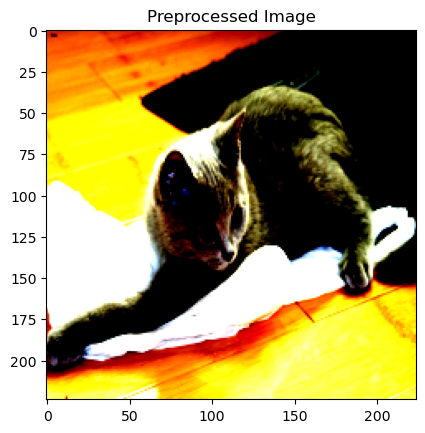

layer  0


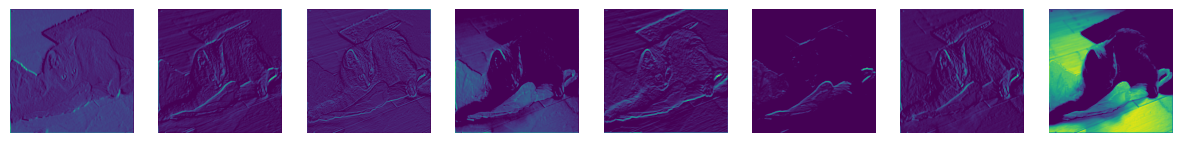

layer  1


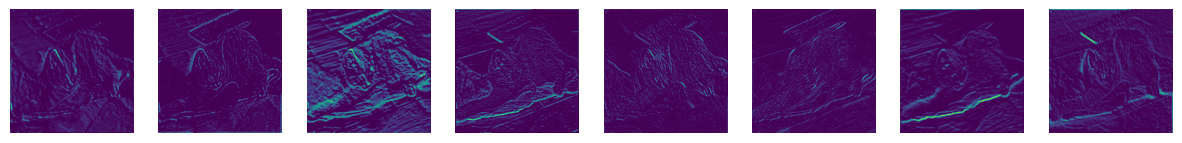

layer  2


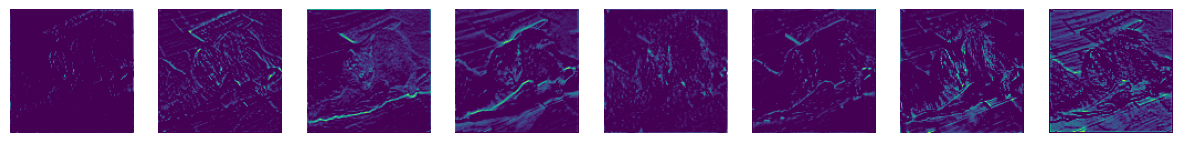

layer  3


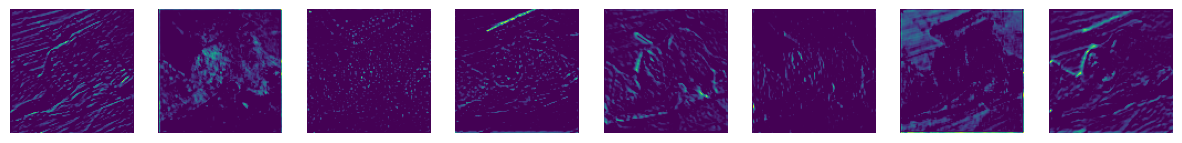

layer  4


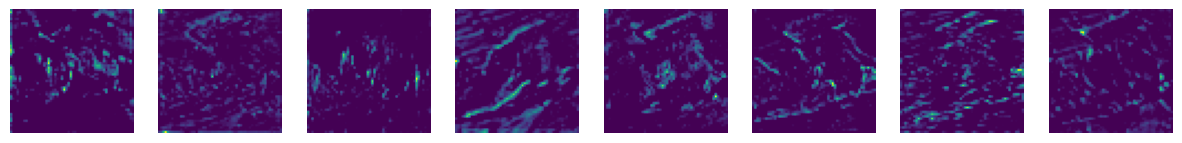

layer  5


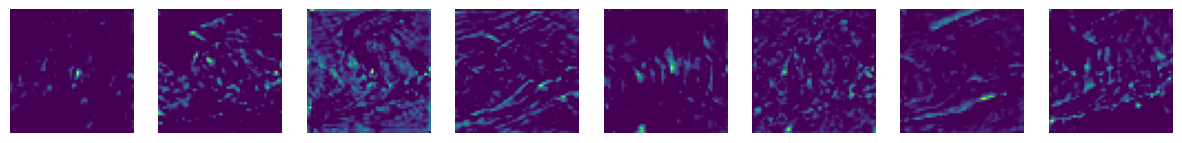

layer  6


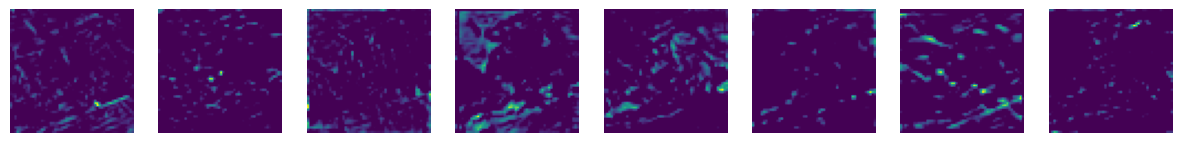

layer  7


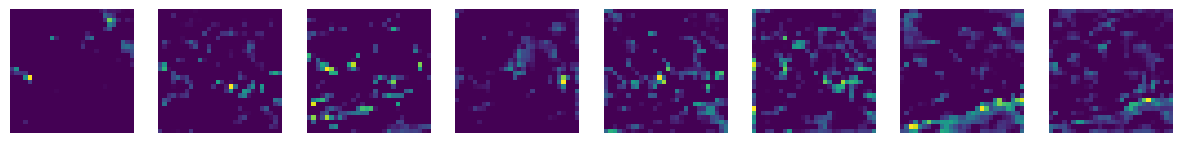

layer  8


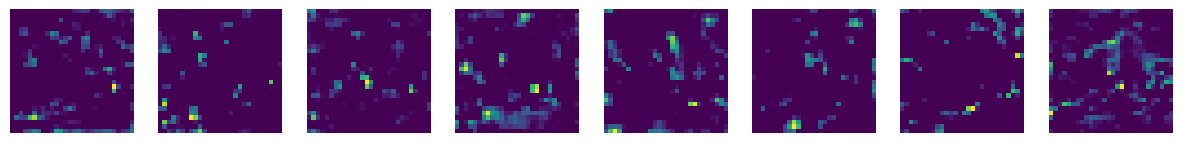

layer  9


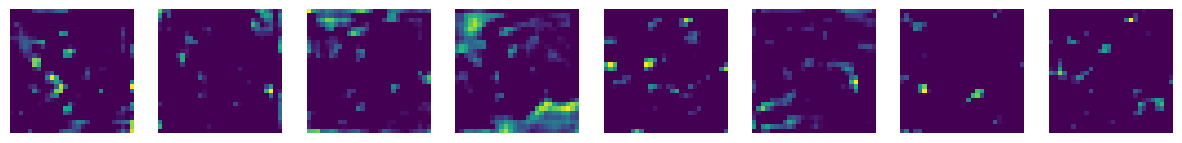

layer  10


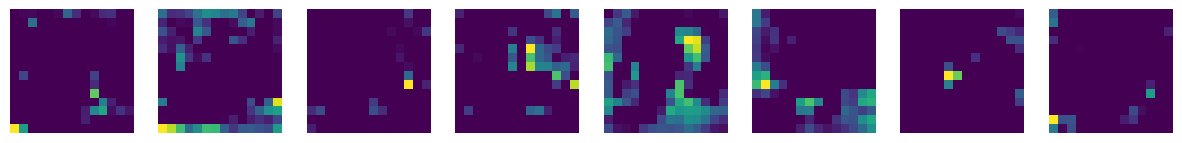

layer  11


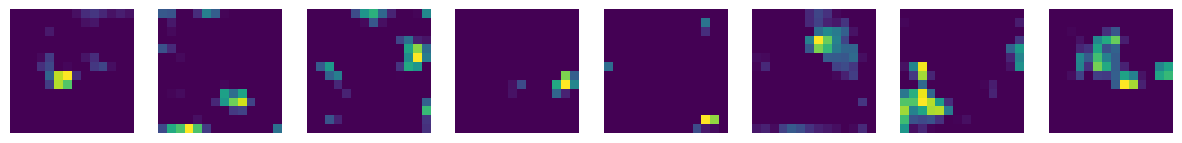

layer  12


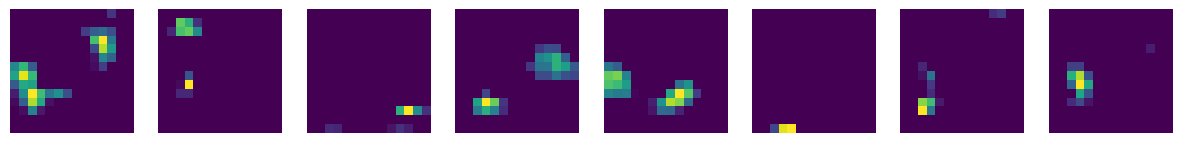

In [22]:
# 테스트 데이터셋에서 샘플 이미지 하나 선택
sample_img, _ = test_data[0]

# 전처리된 상태의 이미지를 보여줌 (Normalize 되어 있음)
plt.title("Preprocessed Image")
plt.imshow(sample_img.permute(1, 2, 0))  # (C, H, W) → (H, W, C)
plt.show()

# VGG16의 13개 convolution layer의 feature map 시각화
# num_layer = 0 ~ 12 : Conv layer 인덱스
for i in range(13):
    visualize_feature_maps(model, sample_img, num_layer=i)

⬆⬆⬆⬆⬆⬆⬆⬆⬆⬆⬆⬆⬆⬆⬆⬆
- preprocessed image: 전처리 완료된 데이터
- 각 필터마다 특징이 뽑혔으면 각 필터별로 어떤 내용을 담고있는지를 통해 고양이와 강아지의 품종을 추측
- 첫 번째 레이어 : 기본적인 엣지, 색상 대비, 텍스처와 같은 저수준 특징을 추출.
- 중간 레이어 : 모서리, 간단한 모양, 복잡한 텍스처 등의 중간 수준 특징을 추출.
- 깊은 레이어 : 고수준의 추상적인 특징을 학습하며, 물체 전체의 구조와 관계를 파악.
- 층이 깊어질수록 개별 이미지는 고차원으 데이터가 추상화 되기 때문에 사람의 경우 오히려 더 각각의 이미지에 담긴 내용을 파악하기 어렵지만 인공지능은 이미지 내에 담긴 잠재적 정보를 파악한다.

In [23]:
# 모델 추론(inference) 결과 확인 함수 정의
def inference_result(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    # 평가 시 gradient 비활성화 (메모리 절약)
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # 모델 추론 (순전파)
            outputs = model(inputs)

            # 예측된 클래스 인덱스 추출
            _, predicted = torch.max(outputs, 1)

    # 첫 번째 배치의 첫 번째 결과만 반환
    return outputs[0], predicted[0], labels[0]

# 인퍼런스 함수 실행
output, predicted, label = inference_result(model, test_loader)

# 모델이 출력한 raw logits 값 (Softmax 전 단계)
print("모델의 인퍼런스 값\n", output)

# 모델이 예측한 클래스 인덱스 (예: 15)
print("모델이 예측한 class :", predicted)

# 실제 라벨 인덱스 (예: 15)
print("실제 class :", label)

모델의 인퍼런스 값
 tensor([-24.1282, -18.8330, -16.5576, -25.6552, -28.1108, -29.5899, -12.4546,
        -30.9459, -28.5066, -21.1105, -15.2356, -23.7314, -27.9525, -23.5807,
        -33.1381,  -9.7233, -28.4752, -24.3284, -11.0797, -18.9877, -18.4816,
        -31.1418, -18.7069, -23.4265, -14.1562, -24.4435, -13.9157, -22.9936,
        -18.7850,  10.4351,  -7.5450,   5.2375, -22.5751, -31.6746,  -9.3381,
        -24.0858, -26.6090])
모델이 예측한 class : tensor(29)
실제 class : tensor(29)


⬆⬆⬆⬆⬆⬆⬆⬆⬆⬆⬆⬆⬆⬆⬆⬆
- 인퍼런스 값의 의미
    - 모델을 통과한 데이터는 최종적으로 class 길이만큼 벡터로 변환.
    - 각각의 값은 해당 클래스의 score이며 score가 0에 가까울수록 해당 클래스일 가능성이 높아지고 낮을수록 해당 클래스일 가능성이 낮아짐.
    - 학습 단계에서 사용하는 손실 함수는 softmax를 사용하며 각 score를 확률 값으로 변환.
    - softmax를 통과하고 나온 벡터는 총합이 1인 확률 벡터.

## 7. CNN에 대해서 더 알아보기

### 7-1. Convolutional Layer

- 각 필터가 동일한 크기의 데이터와 곱연산하고 이를 합산하고 이 과정을 전체 이미지를 슬라이싱하며 최종적으로는 전체 이미지가 필터를 통과한 결과물을 생성
- https://en.wikipedia.org/wiki/Convolutional_neural_network
- https://commons.wikimedia.org/wiki/File:2D_Convolution_Animation.gif

<img src="https://upload.wikimedia.org/wikipedia/commons/1/19/2D_Convolution_Animation.gif" />

### 7-2. 필터의 역할

- https://en.wikipedia.org/wiki/Kernel_(image_processing)

In [24]:
import numpy as np
import matplotlib.pyplot as plt

data = np.zeros((15, 15), dtype=int)
data[3:12, 3:12] = 1
data[6:9, 6:9] = 0
print(data)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 1 1 1 1 1 1 1 0 0 0]
 [0 0 0 1 1 1 1 1 1 1 1 1 0 0 0]
 [0 0 0 1 1 1 1 1 1 1 1 1 0 0 0]
 [0 0 0 1 1 1 0 0 0 1 1 1 0 0 0]
 [0 0 0 1 1 1 0 0 0 1 1 1 0 0 0]
 [0 0 0 1 1 1 0 0 0 1 1 1 0 0 0]
 [0 0 0 1 1 1 1 1 1 1 1 1 0 0 0]
 [0 0 0 1 1 1 1 1 1 1 1 1 0 0 0]
 [0 0 0 1 1 1 1 1 1 1 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [25]:
filter_kernel = np.array([
    [-1, -1, -1],
    [ 0,  0,  0],
    [ 1,  1,  1]
])

print(filter_kernel)

[[-1 -1 -1]
 [ 0  0  0]
 [ 1  1  1]]


In [26]:
def conv(input_data, filter_kernel):
    input_height, input_width = input_data.shape
    filter_height, filter_width = filter_kernel.shape

    output_height = input_height - filter_height + 1
    output_width = input_width - filter_width + 1

    output_data = np.zeros((output_height, output_width))

    for i in range(output_height):
        for j in range(output_width):
            region = input_data[i:i+filter_height, j:j+filter_width]
            output_data[i, j] = np.sum(region * filter_kernel)

    return output_data

input_data = np.array(data)
output_data = conv(input_data, filter_kernel)

print("Output Data:")
print(output_data)


Output Data:
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  2.  3.  3.  3.  3.  3.  3.  3.  2.  1.  0.]
 [ 0.  1.  2.  3.  3.  3.  3.  3.  3.  3.  2.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1. -2. -3. -2. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1. -2. -3. -2. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  2.  3.  2.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  2.  3.  2.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1. -2. -3. -3. -3. -3. -3. -3. -3. -2. -1.  0.]
 [ 0. -1. -2. -3. -3. -3. -3. -3. -3. -3. -2. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


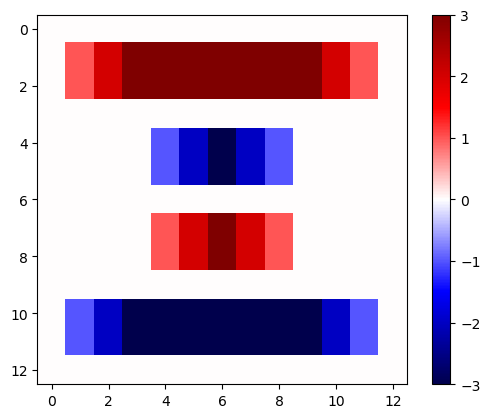

In [27]:
# 시각화
import matplotlib.pyplot as plt

plt.imshow(output_data, cmap="seismic", interpolation="nearest")
plt.colorbar()
plt.show()

## 8. 실습하기

### 8-1. 오버피팅의 의미와 오버피팅을 판별하는 방법

- **의미**
    - 오버피팅 : 모델이 훈련 데이터에만 너무 최적화되어 새 데이터(검증/테스트)에서는 성능이 떨어지는 현상.
- **판별 방법**
    - Train Accuracy ↑, Validation Accuracy ↓ → **성능 괴리 발생**
    - Train Loss ↓, Validation Loss ↑ → **Loss 역전**
    - 에폭 증가할수록 검증 성능이 하락
    - 모델 예측이 너무 복잡하거나 흔들림이 많음

### 8-2. Normalization의 의미와 방법

- **의미**
    - 입력 데이터를 특정 범위나 분포로 맞춰 학습 안정성과 속도를 개선하는 기법.
    - Gradient 폭주 방지, 학습 수렴 속도 증가.
- **방법**
    - Min-Max Scaling:

        <img src="https://latex.codecogs.com/svg.image?x%27=\frac{x-\min}{\max-\min}" />

        → 0~1 범위로 조정

    - Standardization (Z-score):

        <img src="https://latex.codecogs.com/svg.image?x%27=\frac{x-\mu}{\sigma}" />

        → 평균 0, 표준편차 1

    - Batch Normalization / Layer Normalization: 모델 내부에서 중간 feature 정규화
    - L2 Normalization: 벡터 길이를 1로 맞춤

### 8-3. Train / Validation / Test data의 관계

- **Train**: 모델이 실제로 학습하는 데이터
- **Validation**: 학습 중 모델 성능 평가 및 튜닝에 사용
- **Test**: 모든 학습 완료 후 최종 성능 평가
- 중요한 점:
    - Validation은 학습 파라미터 조정용
    - Test는 절대 모델 수정에 사용하면 안 됨
    - 보통 비율: Train 70~80%, Valid 10~15%, Test 10~15%

### 8-4. 머신러닝과 딥러닝의 차이점

- **머신러닝(ML)**:
    - 사람이 특징(feature)을 직접 설계함
    - 모델이 비교적 단순 (SVM, Random Forest 등)
    - 적은 데이터로도 가능
- **딥러닝(DL)**:
    - 신경망 기반 모델이 스스로 특징을 학습함
    - 대량의 데이터 필요
    - 모델 구조가 깊고 복잡 (CNN, RNN, Transformer)
    - GPU 필요성이 더욱 큼

### 8-5. 인공지능 모델의 일반적인 학습 과정

1. 데이터 준비 & 전처리 (정규화, 라벨링 등)
2. Train/Validation/Test 분리
3. 모델 정의
4. Loss 함수 정의
5. Optimizer 정의
6. Forward → Loss → Backward → Optimization 반복
7. Validation으로 과적합 체크
8. 최종적으로 Test Data로 성능 평가

### 8-6. softmax 계산 방식

- Softmax는 여러 클래스의 출력을 확률처럼 보이게 정규화하는 함수.
    
    <img src="https://latex.codecogs.com/svg.image?softmax(x_i)=\frac{e^{x_i}}{\sum_j e^{x_j}}" />

- **특징**:
    - 값 전체를 0~1 확률로 변환
    - 모든 확률의 합은 1
    - 가장 큰 logit 값이 가장 높은 확률로 변환됨
    - CrossEntropyLoss와 함께 분류 모델에서 사용됨